# ENEDIS

## Context 

Our client is a resource manager working for the government. His leadership asked him to investigate
yearly electricity consumption and try to explain it based on external data (demographic, weather,
economic…) in order to forecast years to come in each IRIS or town in France. He has instructed us to
assist him with our expertise.
As part of Accenture Analytics, you integrate the team involved in that project.

In [1]:
# Load needed Libraries 
import pandas as pd # for dataframes
import numpy as np  # for arrays manipulation
import sklearn # for MachineLearning
import re      # to realize manipulation on string with regex
import math
import os      # To download data and save it in directories
import urllib.request

# to make this notebook's output identical at every run
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# To show more column and rows when using df.head()
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Get the Data

First we begin by downloading each files using the website below:
* https://data.enedis.fr/explore/dataset/consommation-electrique-par-secteur-dactivite-iris/information/ for this site, you should click on 2014 on the left panel in order to keep only 2014 values.
* https://www.insee.fr/fr/statistiques/3137421#dictionnaire
* https://www.insee.fr/fr/statistiques/3137412#dictionnaire
* https://www.insee.fr/fr/statistiques/3137409#dictionnaire

Then we will display the first 5 lines using the DataFrame's `head()` method after loading the csv file.

In [2]:
urls = ["https://www.insee.fr/fr/statistiques/fichier/3137421/base-ic-logement-2014.zip",
       "https://www.insee.fr/fr/statistiques/fichier/3137412/base-ic-couples-familles-menages-2014.zip",
       "https://www.insee.fr/fr/statistiques/fichier/3137409/base-ic-evol-struct-pop-2014.zip"]

for url in urls:
    # Split on the rightmost / and take everything on the right side of that as the name of the file
    filename = url.rsplit('/', 1)[-1]
    # Download the file if it does not exist
    if not os.path.isfile(filename):
        urllib.request.urlretrieve(url, filename)

In [3]:
raw_consoPerIris = pd.read_csv('consommation-electrique-par-secteur-dactivite-iris.csv', sep=';', error_bad_lines=False)
raw_consoPerIris.head()

,Année,Nom IRIS,Code IRIS,Type IRIS,Nom commune,Code commune,Nom EPCI,Code EPCI,Type EPCI,Nom département,Code département,Nom région,Code région,Nb sites Résidentiel,Conso totale Résidentiel (MWh),Conso moyenne Résidentiel (MWh),Conso totale Résidentiel usages thermosensibles (MWh),Conso totale Résidentiel usages non thermosensibles (MWh),Conso moyenne Résidentiel usages thermosensibles (MWh),Conso moyenne Résidentiel usages non thermosensibles (MWh),Part thermosensible Résidentiel (%),Thermosensibilité totale Résidentiel (kWh/DJU),Thermosensibilité moyenne Résidentiel (kWh/DJU),Conso totale corrigée de l'aléa climatique Résidentiel usages thermosensibles (MWh),Conso moyenne corrigée de l'aléa climatique Résidentiel usages thermosensibles (MWh),Nb sites Professionnel,Conso totale Professionnel (MWh),Conso moyenne Professionnel (MWh),DJU,Nb sites Agriculture,Conso totale Agriculture (MWh),Nb sites Industrie,Conso totale Industrie (MWh),Nb sites Tertiaire,Conso totale Tertiaire (MWh),Nb sites Autres,Conso totale Autres (MWh),Nombre d'habitants,Taux de logements collectifs,Taux de résidences principales,Superficie des logements < 30 m2,Superficie des logements 30 à 40 m2,Superficie des logements 40 à 60 m2,Superficie des logements 60 à 80 m2,Superficie des logements 80 à 100 m2,Superficie des logements > 100 m2,Résidences principales avant 1919,Résidences principales de 1919 à 1945,Résidences principales de 1946 à 1970,Résidences principales de 1971 à 1990,Résidences principales de 1991 à 2005,Résidences principales de 2006 à 2010,Résidences principales après 2011,Taux de chauffage électrique,geom,geo_point_2d
0,2014,Kerallan-Pen Ar Ch'Leuz,290190157,H,Brest,29019,CU Brest Métropole Océane,242900314,CU,Finistère,29,Bretagne,53,1131.0,4215.912353,3.727597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87.0,706.146914,8.116631,NaN,0,0.000000,0,0.000000,11,3318.677905,NaN,NaN,2370,34.172348,98.648300,0.376911,6.802959,7.680954,16.960795,31.727496,36.450883,1.102964,0.644358,42.114763,43.444992,6.253519,5.315456,1.123948e+00,25.432237,"{""type"": ""Polygon"", ""coordinates"": [[[-4.48005...","48.4198833951,-4.48202272106"
1,2014,Saint-Maden (commune non irisée),223120000,Z,Saint-Maden,22312,CC du Pays de Caulnes,242200608,CC,Côtes-d'Armor,22,Bretagne,53,112.0,623.709867,5.568838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,418.281773,27.885452,NaN,3,378.974534,0,0.000000,1,4.930026,NaN,NaN,209,0.000000,83.478417,0.000000,1.020369,6.122433,18.367300,22.448995,52.040793,65.306138,2.040848,6.122433,12.244867,5.102064,3.061217,6.122433e+00,23.469364,"{""type"": ""Polygon"", ""coordinates"": [[[-2.06717...","48.3375443998,-2.06887454643"
2,2014,Mairie-Marne,641220102,H,Biarritz,64122,CA Agglomération Côte Basque Adour,246400030,CA,Pyrénées-Atlantiques,64,Nouvelle Aquitaine,75,3051.0,6975.434955,2.286278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,559.0,3736.773298,6.684747,NaN,0,0.000000,0,0.000000,16,2217.841899,NaN,NaN,2099,89.397361,45.060531,8.058292,10.295058,18.156013,27.017674,19.705094,16.767869,22.509205,22.889916,30.626204,16.564726,7.048155,0.361795,2.909569e-15,21.882704,"{""type"": ""Polygon"", ""coordinates"": [[[-1.54121...","43.48312051,-1.55115481466"
3,2014,Pave Neuf 4,930510304,H,Noisy-le-Grand,93051,nd,ZZZZZZZZZ,nd,Seine-Saint-Denis,93,Île-de-France,11,1052.0,4999.688278,4.752555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61.0,1042.555107,17.091067,NaN,0,0.000000,0,0.000000,7,1924.048504,NaN,NaN,2868,98.144165,99.410838,17.384205,5.934860,17.166397,34.826914,20.055270,4.632354,0.000000,0.000000,4.546831,78.749197,15.929291,0.482216,2.924654e-01,50.779343,"{""type"": ""Polygon"", ""coordinates"": [[[2.555520...","48.8387930974,2.55864726498"
4,2014,Saint-Yvoine (commune non irisée),634040000,Z,Saint-Yvoine,63404,CC des Coteaux de l'Allier,246300784,CC,Puy-de-Dôme,63,Auvergne-Rhône-Alpes,84,285.0,1606.577786,5.637115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,256.542454,7.774014,NaN,0,0.000000,2,665.442717,3,335.624269,NaN,NaN,560,2.920822,93.047024,0

Let us now load external data which may (or may not) be useful in order to learn more

In [4]:
logement_set = pd.ExcelFile('base-ic-logement-2014.xls')
raw_logement = logement_set.parse('IRIS', skiprows=5, index_col=None, na_values=['NA'])
raw_logement.head()

,IRIS,REG,DEP,UU2010,COM,LIBCOM,TRIRIS,GRD_QUART,LIBIRIS,TYP_IRIS,MODIF_IRIS,LAB_IRIS,P14_LOG,P14_RP,P14_RSECOCC,P14_LOGVAC,P14_MAISON,P14_APPART,P14_RP_1P,P14_RP_2P,P14_RP_3P,P14_RP_4P,P14_RP_5PP,P14_NBPI_RP,P14_RPMAISON,P14_NBPI_RPMAISON,P14_RPAPPART,P14_NBPI_RPAPPART,P14_RP_M30M2,P14_RP_3040M2,P14_RP_4060M2,P14_RP_6080M2,P14_RP_80100M2,P14_RP_100120M2,P14_RP_120M2P,P14_RP_ACHTOT,P14_RP_ACH19,P14_RP_ACH45,P14_RP_ACH70,P14_RP_ACH90,P14_RP_ACH05,P14_RP_ACH11,P14_RPMAISON_ACHTOT,P14_RPMAISON_ACH19,P14_RPMAISON_ACH45,P14_RPMAISON_ACH70,P14_RPMAISON_ACH90,P14_RPMAISON_ACH05,P14_RPMAISON_ACH11,P14_RPAPPART_ACHTOT,P14_RPAPPART_ACH19,P14_RPAPPART_ACH45,P14_RPAPPART_ACH70,P14_RPAPPART_ACH90,P14_RPAPPART_ACH05,P14_RPAPPART_ACH11,P14_MEN,P14_MEN_ANEM0002,P14_MEN_ANEM0204,P14_MEN_ANEM0509,P14_MEN_ANEM10P,P14_PMEN,P14_PMEN_ANEM0002,P14_PMEN_ANEM0204,P14_PMEN_ANEM0509,P14_PMEN_ANEM10P,P14_NBPI_RP_ANEM0002,P14_NBPI_RP_ANEM0204,P14_NBPI_RP_ANEM0509,P14_NBPI_RP_ANEM10P,P14_RP_PROP,P14_RP_LOC,P14_RP_LOCHLMV,P14_RP_GRAT,P14_NPER_RP,P14_NPER_RP_PROP,P14_NPER_RP_LOC,P14_NPER_RP_LOCHLMV,P14_NPER_RP_GRAT,P14_ANEM_RP,P14_ANEM_RP_PROP,P14_ANEM_RP_LOC,P14_ANEM_RP_LOCHLMV,P14_ANEM_RP_GRAT,P14_RP_SDB,P14_RP_CCCOLL,P14_RP_CCIND,P14_RP_CINDELEC,P14_RP_ELEC,P14_RP_EAUCH,P14_RP_BDWC,P14_RP_CHOS,P14_RP_CLIM,P14_RP_TTEGOU,P14_RP_GARL,P14_RP_VOIT1P,P14_RP_VOIT1,P14_RP_VOIT2P,P14_RP_HABFOR,P14_RP_CASE,P14_RP_MIBOIS,P14_RP_MIDUR
0,010010000,84,01,01000,01001,L'Abergement-Clémenciat,ZZZZZZ,0100100,L'Abergement-Clémenciat (commune non irisée),Z,0,5,342.734735,306.000000,13.994185,22.740550,335.110825,5.749273,1.000000,3.000000,21.000000,100.000000,181.000000,1521.000000,301.000000,1507.000000,4.000000,10.000000,1.000000,2.000000,4.000000,40.000000,81.000000,74.000000,104.000000,293.000000,84.000000,9.000000,8.000000,94.000000,90.000000,8.000000,288.000000,83.000000,9.000000,6.000000,92.000000,90.000000,8.000000,4.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,306.000000,24.000000,41.000000,36.000000,205.000000,767.000000,60.000000,122.000000,107.000000,478.000000,112.000000,203.000000,179.000000,1027.000000,260.000000,41.000000,8.000000,5.000000,767.000000,669.000000,86.000000,19.000000,12.000000,5483.000000,4972.000000,376.000000,60.000000,135.000000,301.000000,7.000000,150.000000,67.000000,NaN,NaN,NaN,NaN,NaN,NaN,261.000000,292.000000,100.000000,192.000000,NaN,NaN,NaN,NaN
1,010020000,84,01,01000,01002,L'Abergement-de-Varey,ZZZZZZ,0100200,L'Abergement-de-Varey (commune non irisée),Z,0,5,161.160233,99.337449,47.276247,14.546538,161.160233,0.000000,1.967078,1.967078,13.769547,29.506173,52.127572,471.115226,99.337449,471.115226,0.000000,0.000000,0.000000,0.983539,5.901235,7.868313,24.588477,19.670782,40.325103,95.403292,53.111111,9.835391,6.884774,7.868313,11.802469,5.901235,95.403292,53.111111,9.835391,6.884774,7.868313,11.802469,5.901235,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,99.337449,11.802469,14.753086,26.555556,46.226337,239.000000,29.506173,35.407407,69.831276,104.255144,56.061728,67.864198,118.024691,229.164609,84.584362,11.802469,0.000000,2.950617,239.000000,209.493827,26.555556,0.000000,2.950617,1433.016461,1355.316872,58.028807,0.000000,19.670782,96.386831,0.983539,50.160494,17.703704,NaN,NaN,NaN,NaN,NaN,NaN,74.748971,96.386831,28.522634,67.864198,NaN,NaN,NaN,NaN
2,010040101,84,01,01302,01004,Ambérieu-en-Bugey,ZZZZZZ,0100401,Les Perouses-Triangle d'Activite,H,0,1,827.982997,719.327645,17.736328,90.919024,317.098225,485.416937,126.108139,58.863456,174.818792,219.061206,140.476052,2443.280946,279.107297,1296.805424,418.118527,1118.561326,134.652478,17.262783,107.102430,170.480899,189.265783,54.263661,46.299611,677.640838,32.547722,86.972813,92.817027,301.642625,142.947033,20.713619,250.107780,25.297843,35.317422,65.737604,105.324402,11.180629,7.249879,405.431238,7.249879,51.655391,27.079423,187.680142,118.302664,13.463739,719.327645,135.264729,192.306201,97.811316,293.945399,1391.485087,198.045783,376.940779,248.532957

We will first study the `logement_set` which I feel it seems promising and then `menages_set` and `population_set` if we have time.

# Prepare and describe the data

Once you get enough data, you will need to clean, aggregate, analyze and describe the datasets. For
that, use any approach you feel relevant and indicate your motivations.
Present one (or more) analysis (graphs, metrics, tables, etc.) which seems the most pertinent to you
to explain electricity consumption while answering the following questions:

1. Is electricity consumption explainable from external data?
2. What are the features, or group of features correlated with electricity consumption?
3. There might be a lot of dimensions in your data, how can you reduce dimensionality while keeping a maximum of information?
4. Are there major differences in consumption by department or region? If so, what are these differences? Propose some reason behind these differences
5. Which departments have a large variation in electricity consumption? A small variation?

In order to get insight we will explore the data and process some information. We will try explain each step of our process. If we write `raw_consoPerIris.describe(include='all')` it will show that there is 48657 values which are all unique for the `Code IRIS` (by definition of an IRIS it is obvious). Therefore it will be a great way to join our dataset with external dataset by joining on that column.

In [5]:
raw_consoPerIris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48657 entries, 0 to 48656
Data columns (total 56 columns):
Année                                                                                   48657 non-null int64
Nom IRIS                                                                                48657 non-null object
Code IRIS                                                                               48657 non-null object
Type IRIS                                                                               48657 non-null object
Nom commune                                                                             48657 non-null object
Code commune                                                                            48657 non-null int64
Nom EPCI                                                                                48657 non-null object
Code EPCI                                                                               48657 non-null object
Type EPCI    

First, in the dataset given by enedis, we see that there are information which won't be useful to keep. For example the column year is not useful because for each value it contains 2014. The `nom commune`, `code commune`, `nom EPCI`, `Nom IRIS`, `Code EPCI`, `Code Region`, `Code département` are either redundant information (`Nom region` vs `Code région`) or identifier of a very specific subset of data which could be represent data too specific to study for our algorithm. We keep `Code Iris` to join our dataset with an INSEE dataset later.

Furthermore, we could extract longitude and latitude to from the `geo_point_2d` and then drop that column. We also need to transform the `Nom region` and `Nom département` into category type

In [6]:
#Delete columns with only NULL value and then raws with no consumption 
conso_per_iris_set = raw_consoPerIris.dropna(axis='columns', how='all')

#Drop unrelevant column
conso_per_iris_set = conso_per_iris_set.drop(['Nom IRIS', 'Nom commune', 'Nom EPCI', 'Code EPCI', 'Code département', 
                                  'Code région', 'Code commune', 'Année', 'geom'], axis=1)

conso_per_iris_set[['Latitude','Longitude']] = conso_per_iris_set.geo_point_2d.str.split(",",expand=True)
conso_per_iris_set['Latitude'] = conso_per_iris_set['Latitude'].astype("float")
conso_per_iris_set['Longitude'] = conso_per_iris_set['Longitude'].astype("float")
conso_per_iris_set = conso_per_iris_set.drop(['geo_point_2d'], axis=1)


conso_per_iris_set['Nom région'] = conso_per_iris_set['Nom région'].astype("category")
conso_per_iris_set['Nom département'] = conso_per_iris_set['Nom département'].astype("category")

In [7]:
conso_per_iris_set.head(20)

,Code IRIS,Type IRIS,Type EPCI,Nom département,Nom région,Nb sites Résidentiel,Conso totale Résidentiel (MWh),Conso moyenne Résidentiel (MWh),Nb sites Professionnel,Conso totale Professionnel (MWh),Conso moyenne Professionnel (MWh),Nb sites Agriculture,Conso totale Agriculture (MWh),Nb sites Industrie,Conso totale Industrie (MWh),Nb sites Tertiaire,Conso totale Tertiaire (MWh),Nombre d'habitants,Taux de logements collectifs,Taux de résidences principales,Superficie des logements < 30 m2,Superficie des logements 30 à 40 m2,Superficie des logements 40 à 60 m2,Superficie des logements 60 à 80 m2,Superficie des logements 80 à 100 m2,Superficie des logements > 100 m2,Résidences principales avant 1919,Résidences principales de 1919 à 1945,Résidences principales de 1946 à 1970,Résidences principales de 1971 à 1990,Résidences principales de 1991 à 2005,Résidences principales de 2006 à 2010,Résidences principales après 2011,Taux de chauffage électrique,Latitude,Longitude
0,290190157,H,CU,Finistère,Bretagne,1131.0,4215.912353,3.727597,87.0,706.146914,8.116631,0,0.000000,0,0.000000,11,3318.677905,2370,34.172348,98.648300,0.376911,6.802959,7.680954,16.960795,31.727496,36.450883,1.102964,0.644358,42.114763,43.444992,6.253519,5.315456,1.123948e+00,25.432237,48.419883,-4.482023
1,223120000,Z,CC,Côtes-d'Armor,Bretagne,112.0,623.709867,5.568838,15.0,418.281773,27.885452,3,378.974534,0,0.000000,1,4.930026,209,0.000000,83.478417,0.000000,1.020369,6.122433,18.367300,22.448995,52.040793,65.306138,2.040848,6.122433,12.244867,5.102064,3.061217,6.122433e+00,23.469364,48.337544,-2.068875
2,641220102,H,CA,Pyrénées-Atlantiques,Nouvelle Aquitaine,3051.0,6975.434955,2.286278,559.0,3736.773298,6.684747,0,0.000000,0,0.000000,16,2217.841899,2099,89.397361,45.060531,8.058292,10.295058,18.156013,27.017674,19.705094,16.767869,22.509205,22.889916,30.626204,16.564726,7.048155,0.361795,2.909569e-15,21.882704,43.483121,-1.551155
3,930510304,H,nd,Seine-Saint-Denis,Île-de-France,1052.0,4999.688278,4.752555,61.0,1042.555107,17.091067,0,0.000000,0,0.000000,7,1924.048504,2868,98.144165,99.410838,17.384205,5.934860,17.166397,34.826914,20.055270,4.632354,0.000000,0.000000,4.546831,78.749197,15.929291,0.482216,2.924654e-01,50.779343,48.838793,2.558647
4,634040000,Z,CC,Puy-de-Dôme,Auvergne-Rhône-Alpes,285.0,1606.577786,5.637115,33.0,256.542454,7.774014,0,0.000000,2,665.442717,3,335.624269,560,2.920822,93.047024,0.000000,3.083683,7.488968,14.977978,25.110109,49.339220,27.312751,7.929530,8.810570,21.145386,20.264303,14.537458,0.000000e+00,29.955957,45.574990,3.225764
5,371790000,Z,CA,Indre-et-Loire,Centre-Val de Loire,1035.0,6920.677502,6.686645,280.0,3308.371894,11.815614,1,15.247099,12,1334.996014,54,21594.593774,2292,7.743703,98.517986,0.108338,1.300108,5.308779,16.251352,29.902488,47.128935,9.967500,2.275191,10.834235,36.836400,31.744318,5.850490,2.491867e+00,34.127847,47.452141,0.742574
6,543290102,H,CC,Meurthe-et-Moselle,Grand-Est,1527.0,4799.668504,3.143201,346.0,2389.051440,6.904773,1,18.419652,1,3.271447,20,3166.058025,2754,78.040631,99.455892,3.374031,7.340469,15.472990,25.952056,23.761841,24.098605,41.032080,3.238672,33.040394,11.478961,8.658937,0.938103,1.612853e+00,19.800979,48.596066,6.503931
7,174760000,Z,CC,Charente-Maritime,Nouvelle Aquitaine,123.0,718.236862,5.839324,24.0,85.995345,3.583139,0,0.000000,1,79.278156,0,0.000000,257,4.356768,92.620281,0.854740,2.564132,3.418784,11.111091,21.367531,60.683721,41.025671,5.128175,11.111091,17.094007,18.803399,6.837567,8.912831e-05,23.931574,45.378684,-0.439593
8,315553001,H,CU,Haute-Garonne,Occitanie,854.0,2346.464130,2.747616,86.0,644.919376,7.499063,0,0.000000,0,0.000000,6,647.234944,1845,70.023705,98.100933,1.895303,1.445848,16.708921,32.554831,34.811966,12.583130,0.658553,1.327446,59.280206,31.372649,2.156649,2.105326,3.099171e+00,2.293490,43.577992,1.415052
9,801550000,Z,CC,Somme,Hauts-de-France,122.0,678.925639,5.564964,15.0,152.031914,10.135461,2,77.323205,0,0.000000,1,3.274246,322,0.000000,93.547149,1.724136,

According to the documentation, there are only four types of IRIS:
* H
* A
* D
* Z

Documentation :

« Par extension, afin de couvrir l'ensemble du territoire, on assimile à un IRIS chacune des communes
non découpées en IRIS. On parle d’IRIS de type Z.
On distingue trois types d'IRIS :
- Type H, « IRIS d'habitat : leur population se situe en général entre 1 800 et 5 000 habitants. Ils sont homogènes quant au type d'habitat et leurs limites s'appuient sur les grandes coupures du tissu urbain (voies principales, voies ferrées, cours d'eau...) »
- Type A, « IRIS d'activité : ils regroupent plus de 1 000 salariés et comptent au moins deux fois plus d'emplois salariés que de population résidente »
- Type D, « IRIS « divers » : il s'agit de grandes zones spécifiques peu habitées et ayant une superficie importante (parcs de loisirs, zones portuaires, forêts...)»

»

In [8]:
# Drop rows with undefined values
conso_per_iris_set = conso_per_iris_set[~conso_per_iris_set['Type IRIS'].isin(['_', '0'])]
conso_per_iris_set["Type IRIS"] = conso_per_iris_set["Type IRIS"].astype('category')
conso_per_iris_set["Type IRIS"].value_counts()

Z    32055
H    13687
A      772
D      299
Name: Type IRIS, dtype: int64

According to the documentation, there are only five types of EPCI:
* CU
* CA
* CC
* SA
* ME

"Les informations présentées ici concernent les EPCI à fiscalité propre :
Communauté Urbaine (CU), Communauté d'Agglomération (CA), Communauté de Communes (CC),
Syndicat d'Agglomération (SA), Métropole (ME)."

In [9]:
# Drop rows with undefined values
conso_per_iris_set = conso_per_iris_set[~conso_per_iris_set['Type EPCI'].isin(['nd'])]
conso_per_iris_set["Type EPCI"].replace("SAN", "SA", inplace=True)
conso_per_iris_set["Type EPCI"] = conso_per_iris_set["Type EPCI"].astype('category')
conso_per_iris_set["Type EPCI"].value_counts()

CC    30552
CA    11501
CU     2832
ME      235
SA       90
Name: Type EPCI, dtype: int64

As we have defined the above types (EPCI and IRIS) as catergories it could be interersting to see if they are relevant to our study.

You can change `Type IRIS` by `Type EPCI` to see the effect of each features. On the `totale` features the type of EPCI and IRIS seem to change a lot. However for `moyenne` features the impact is <strong>relatively</strong> low. 

In [10]:
table = pd.pivot_table(conso_per_iris_set, values=['Conso totale Résidentiel (MWh)'], index=['Type EPCI'],aggfunc=np.mean)
table

,Conso totale Résidentiel (MWh)
Type EPCI,
CA,4496.714470
CC,2527.686488
CU,4615.451327
ME,5538.240647
SA,5994.929627


If we want to use these to features we need to use OneHotEncoder.

In [11]:
from sklearn.preprocessing import OneHotEncoder

hot_encoder = OneHotEncoder()
conso_per_iris_hot = hot_encoder.fit_transform(conso_per_iris_set[["Type IRIS", "Type EPCI"]])

However for the moment we won't keep these features in our study.

We replace NaN values in the consumption and number of sites features by 0 value except for `Conso moyenne Résidentiel (MWh)`, `Conso totale Résidentiel (MWh)` and `Nb sites Résidentiel` because rows containing a NaN values for thoose features will be removed.

In [12]:
conso_per_iris_set[["Conso moyenne Professionnel (MWh)", "Conso totale Professionnel (MWh)", 
                 "Conso totale Agriculture (MWh)", "Conso totale Industrie (MWh)", 
                 "Conso totale Tertiaire (MWh)", "Nb sites Professionnel", "Nb sites Agriculture", 
                    "Nb sites Industrie", "Nb sites Tertiaire"]
                  ]= conso_per_iris_set[["Conso moyenne Professionnel (MWh)", "Conso totale Professionnel (MWh)", 
                 "Conso totale Agriculture (MWh)", "Conso totale Industrie (MWh)", 
                 "Conso totale Tertiaire (MWh)", "Nb sites Professionnel", "Nb sites Agriculture", 
                    "Nb sites Industrie", "Nb sites Tertiaire"]].fillna(0)

In [13]:
conso_per_iris_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45210 entries, 0 to 48656
Data columns (total 36 columns):
Code IRIS                                45210 non-null object
Type IRIS                                45210 non-null category
Type EPCI                                45210 non-null category
Nom département                          45210 non-null category
Nom région                               45210 non-null category
Nb sites Résidentiel                     41257 non-null float64
Conso totale Résidentiel (MWh)           41257 non-null float64
Conso moyenne Résidentiel (MWh)          41257 non-null float64
Nb sites Professionnel                   45210 non-null float64
Conso totale Professionnel (MWh)         45210 non-null float64
Conso moyenne Professionnel (MWh)        45210 non-null float64
Nb sites Agriculture                     45210 non-null int64
Conso totale Agriculture (MWh)           45210 non-null float64
Nb sites Industrie                       45210 non-null in

We see that we have still some information with NaN values as expected. We will drop these few lines (try execute conso_per_iris_set.info() after the command, it will show that there in non null values anymore)

In [14]:
conso_per_iris_set = conso_per_iris_set.dropna()

In [15]:
conso_per_iris_set.describe(include='all')

,Code IRIS,Type IRIS,Type EPCI,Nom département,Nom région,Nb sites Résidentiel,Conso totale Résidentiel (MWh),Conso moyenne Résidentiel (MWh),Nb sites Professionnel,Conso totale Professionnel (MWh),Conso moyenne Professionnel (MWh),Nb sites Agriculture,Conso totale Agriculture (MWh),Nb sites Industrie,Conso totale Industrie (MWh),Nb sites Tertiaire,Conso totale Tertiaire (MWh),Nombre d'habitants,Taux de logements collectifs,Taux de résidences principales,Superficie des logements < 30 m2,Superficie des logements 30 à 40 m2,Superficie des logements 40 à 60 m2,Superficie des logements 60 à 80 m2,Superficie des logements 80 à 100 m2,Superficie des logements > 100 m2,Résidences principales avant 1919,Résidences principales de 1919 à 1945,Résidences principales de 1946 à 1970,Résidences principales de 1971 à 1990,Résidences principales de 1991 à 2005,Résidences principales de 2006 à 2010,Résidences principales après 2011,Taux de chauffage électrique,Latitude,Longitude
count,40595,40595,40595,40595,40595,40595.000000,40595.000000,40595.000000,40595.000000,40595.000000,40595.000000,40595.000000,40595.000000,40595.000000,40595.000000,40595.000000,40595.000000,40595.000000,40595.000000,40595.000000,40595.000000,40595.000000,40595.000000,40595.000000,40595.000000,40595.000000,40595.000000,40595.000000,40595.000000,40595.000000,40595.000000,40595.000000,40595.000000,40595.000000,40595.000000,40595.000000
unique,40595,4,5,93,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,764700000,Z,CC,Nord,Auvergne-Rhône-Alpes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,27664,26338,1304,5127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,701.437566,3251.070262,5.247979,97.600222,915.728050,9.073051,0.635645,68.274527,1.867496,1355.058536,7.524572,1878.809000,1367.338244,23.310186,88.629865,2.156184,3.468737,10.101747,18.516517,25.268701,40.401896,23.856244,9.272695,16.847138,25.937902,14.485939,6.887115,2.626754,24.772849,46.938296,2.601786
std,NaN,NaN,NaN,NaN,NaN,728.970066,3108.832253,1.639896,122.508050,1179.179797,3.274239,1.827674,384.832945,3.704938,6370.648764,14.463313,5306.608213,1235.380061,30.515832,15.201417,4.871506,4.173785,8.281233,9.690284,7.920192,18.584390,18.943649,8.850616,15.153960,14.278077,9.464344,5.766027,3.533922,14.099760,2.245555,2.562696
min,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,42.356385,-4.960099
25%,NaN,NaN,NaN,NaN,NaN,166.000000,945.711451,4.019856,25.000000,194.162462,6.822869,0.000000,0.000000,0.000000,0.000000,1.000000,1.577417,323.000000,2.157323,84.814221,0.000000,0.884922,4.260925,11.805560,20.378849,27.490886,7.729738,3.937038,7.216495,16.550497,7.769959,2.849870,0.233030,14.426266,45.026014,0.781824
50%,NaN,NaN,NaN,NaN,NaN,433.000000,2272.497655,5.374283,53.000000,502.638579,8.845206,0.000000,0.000000,1.000000,18.931424,3.000000,289.411025,900.000000,7.732098,95.020142,0.716614,2.066134,7.611235,16.814159,25.698335,42.926838,20.802371,7.103824,11.864407,24.055671,13.333279,5.825243,1.531385,23.469362,47.324224,2.510106
75%,NaN,NaN,NaN,NaN,NaN,1085.000000,4652.352828,6.420398,125.000000,1183.014754,10.916497,0.000000,0.000000,2.000000,313.501156,9.000000,1661.597662,2225.000000,33.671293,98.582016,1.869181,4.409389,13.525114,23.217078,30.337078,53.846154,36.170258,11.627907,20.761869,32.241715,19.630691,9.621125,3.773585,33.416619,48.833914,4.720790


Now we display the histogram of value for each features. We will be able to see which features need to be scaled and also which features need to have its outliers deleted

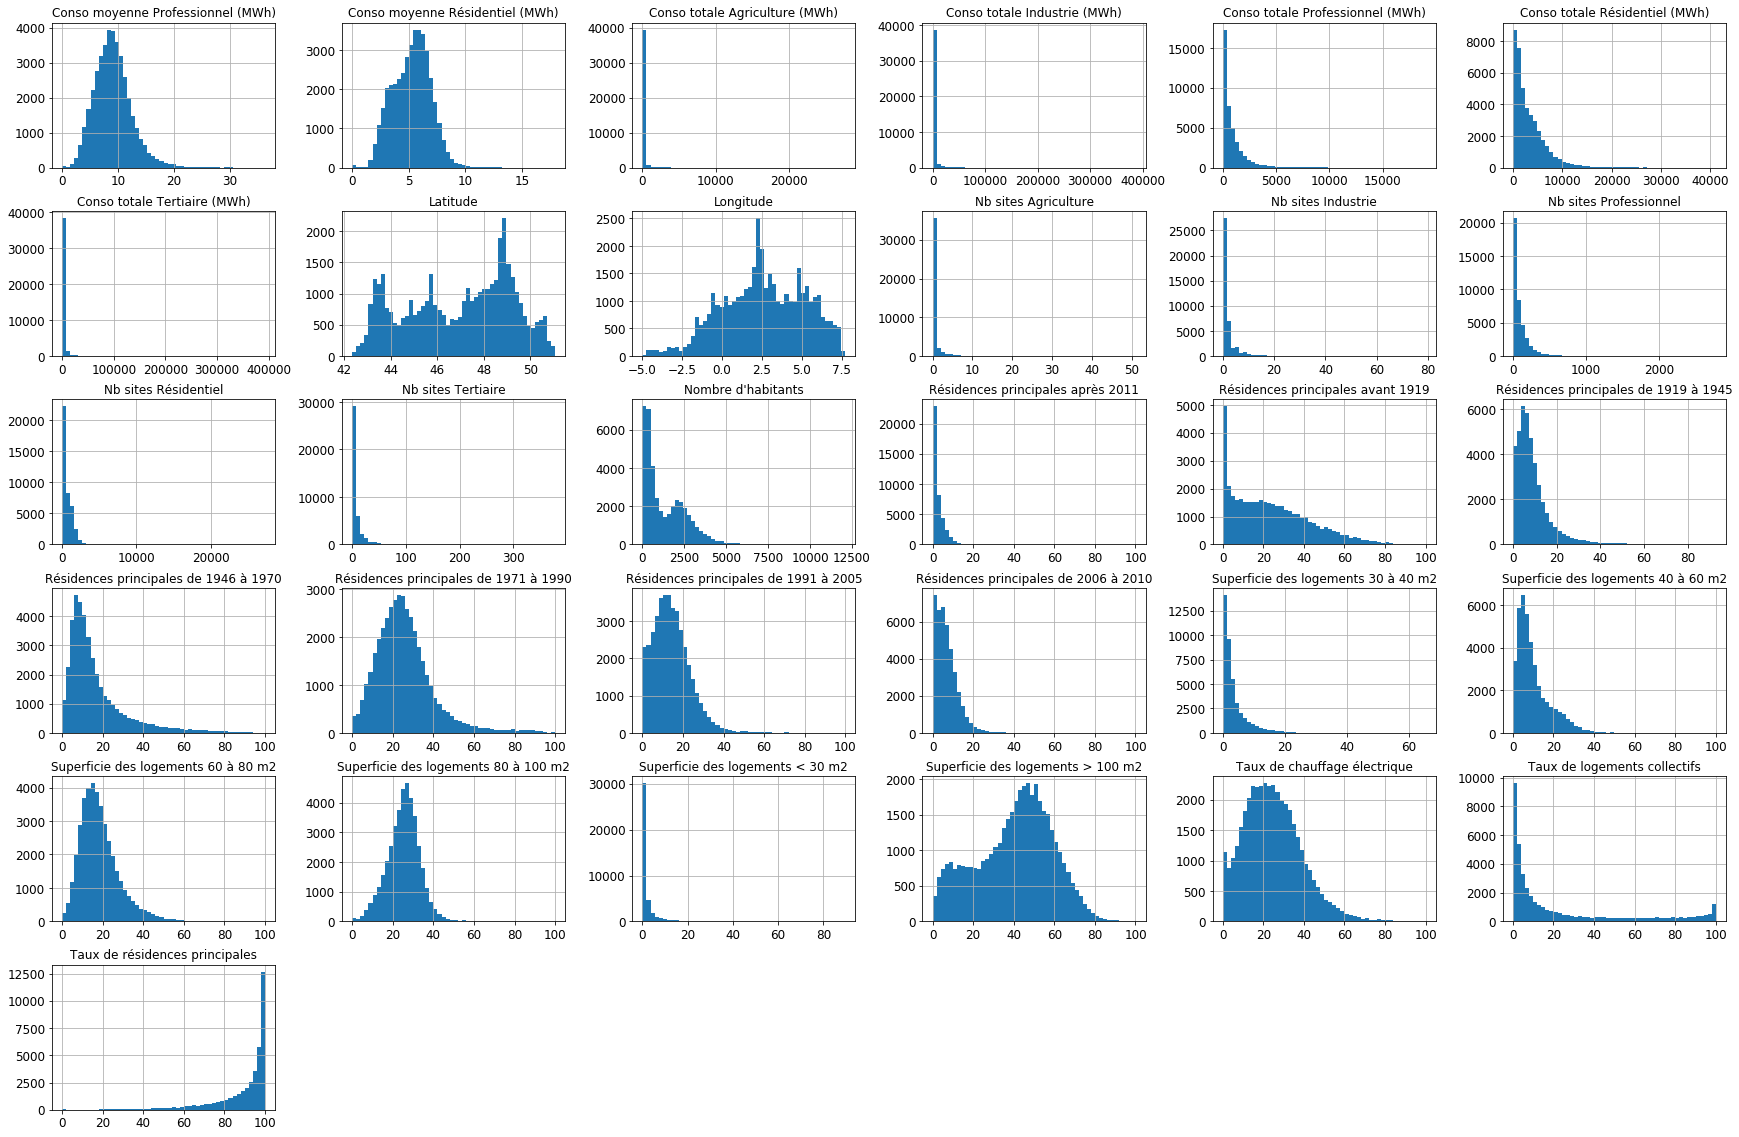

In [16]:
conso_per_iris_set.hist(bins=50, figsize=(30,20))
plt.show();

## Study of outliers

Looking at the histogram above allow us to see if there is any outliers.

So first we will study one by one the total consumption as a function of number of sites.

We will also study the consumption for other types than residential but just for outliers and we will drop these features.

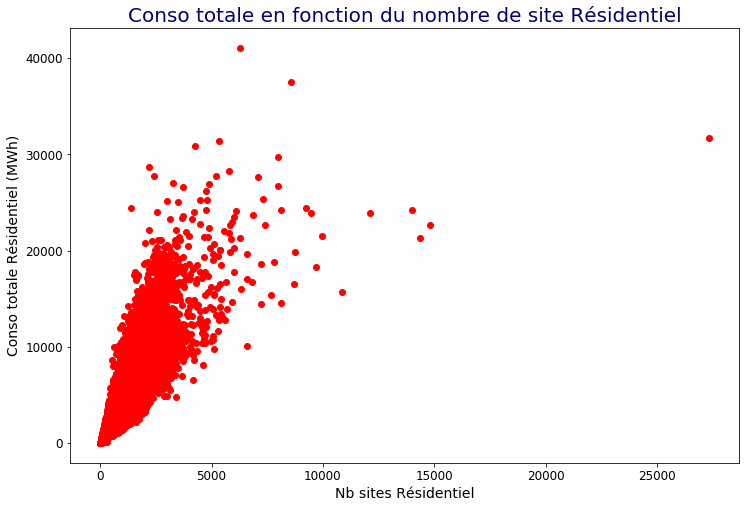

In [17]:
plt.close()
fig = plt.figure(figsize=(12,8))
ax = plt.axes()

plt.rcParams.update({'font.size': 15})

plt.scatter(conso_per_iris_set['Nb sites Résidentiel'], conso_per_iris_set['Conso totale Résidentiel (MWh)'],
         c='#FF0000')

plt.title("Conso totale en fonction du nombre de site Résidentiel", size=20, color="#000070")

# Titres des axes
ax = ax.set(xlabel='Nb sites Résidentiel', ylabel='Conso totale Résidentiel (MWh)')
plt.show()

Here, it does not seem to be any outlier which we absolutely need to get rid of. However when the number of sites is greater than 10000 or when the total consumption is greater than 30000 MWh, we clearly do not have enough data so we will drop this rows. These treshold were also determined with the help of the histogram (few lines above).

In [18]:
conso_per_iris_set = conso_per_iris_set[conso_per_iris_set['Nb sites Résidentiel'] <= 6500]  
conso_per_iris_set = conso_per_iris_set[conso_per_iris_set['Conso totale Résidentiel (MWh)'] <= 25000]  

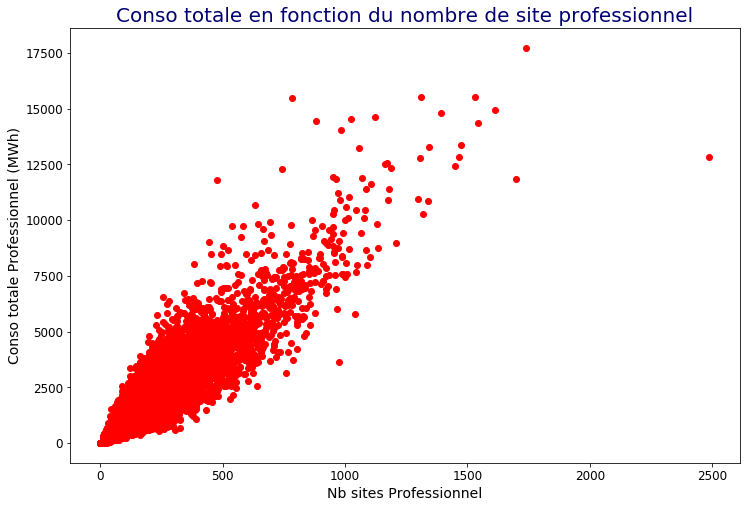

In [19]:
plt.close()
fig = plt.figure(figsize=(12,8))
ax = plt.axes()

plt.rcParams.update({'font.size': 15})

plt.scatter(conso_per_iris_set['Nb sites Professionnel'], conso_per_iris_set['Conso totale Professionnel (MWh)'],
         c='#FF0000')

plt.title("Conso totale en fonction du nombre de site professionnel", size=20, color="#000070")

# Titres des axes
ax = ax.set(xlabel='Nb sites Professionnel', ylabel='Conso totale Professionnel (MWh)')
plt.show()

Here again, if we put aside the three dot on the top right corner, we don't see any outliers. Moreover we do not have a lot of value to train on when `Conso totale Professionnel` is greater than 12000 MWh or `Nb sites Professionnel` is greater than 1250. Again these treshold were also determined with the help of the histogram (few lines above).

In [20]:
# If we had to study the consumption of professionals we would do as below
#conso_per_iris_set = conso_per_iris_set[conso_per_iris_set['Nb sites Professionnel'] <= 1250]  
#conso_per_iris_set = conso_per_iris_set[conso_per_iris_set['Conso totale Professionnel (MWh)'] <= 12000]  

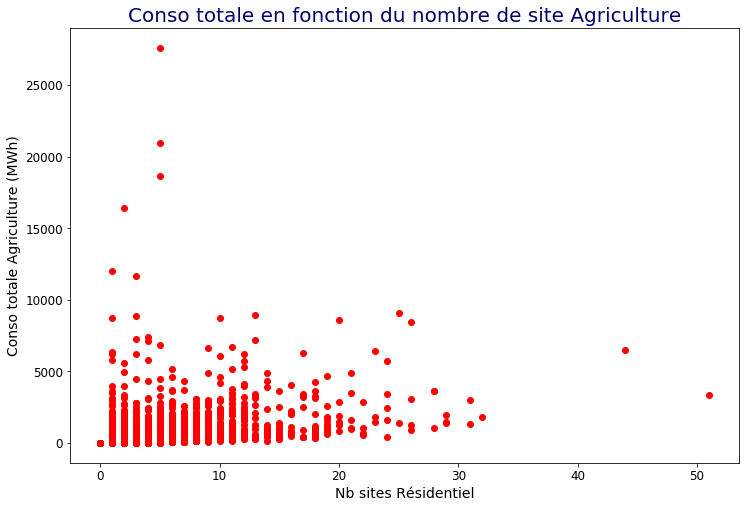

In [21]:
plt.close()
fig = plt.figure(figsize=(12,8))
ax = plt.axes()

plt.rcParams.update({'font.size': 15})

plt.scatter(conso_per_iris_set['Nb sites Agriculture'], conso_per_iris_set['Conso totale Agriculture (MWh)'],
         c='#FF0000')

plt.title("Conso totale en fonction du nombre de site Agriculture", size=20, color="#000070")

# Titres des axes
ax = ax.set(xlabel='Nb sites Résidentiel', ylabel='Conso totale Agriculture (MWh)')
plt.show()

With the histogram above, we can clearly say that we do not have enough data when the number os residential sites is greater than 20 or when the total consumption is greater than 6000

In [22]:
# If we had to study the consumption for Agriculture we would do as below
#conso_per_iris_set = conso_per_iris_set[conso_per_iris_set['Nb sites Agriculture'] < 20]
#conso_per_iris_set = conso_per_iris_set[conso_per_iris_set['Conso totale Agriculture (MWh)'] <= 6000]  

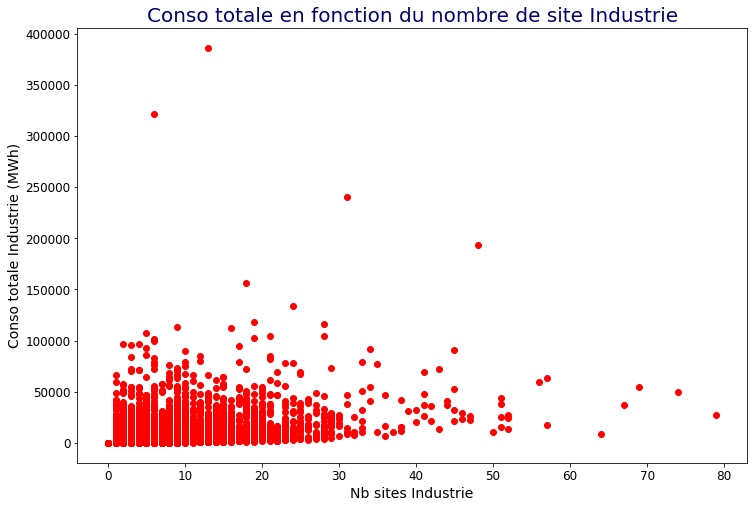

In [23]:
plt.close()
fig = plt.figure(figsize=(12,8))
ax = plt.axes()

plt.rcParams.update({'font.size': 15})

plt.scatter(conso_per_iris_set['Nb sites Industrie'], conso_per_iris_set['Conso totale Industrie (MWh)'],
         c='#FF0000')

plt.title("Conso totale en fonction du nombre de site Industrie", size=20, color="#000070")

# Titres des axes
ax = ax.set(xlabel='Nb sites Industrie', ylabel='Conso totale Industrie (MWh)')
plt.show()

With similar observation as above we will drop values where the number of sites is greater than 33 or where the total consumption is greater than 80000 (cf histogram few lines above).

In [24]:
# If we had to study the consumption for Industrie we would do as below
#conso_per_iris_set = conso_per_iris_set[conso_per_iris_set['Nb sites Industrie'] <= 33]
#conso_per_iris_set = conso_per_iris_set[conso_per_iris_set['Conso totale Industrie (MWh)'] <= 80000]  

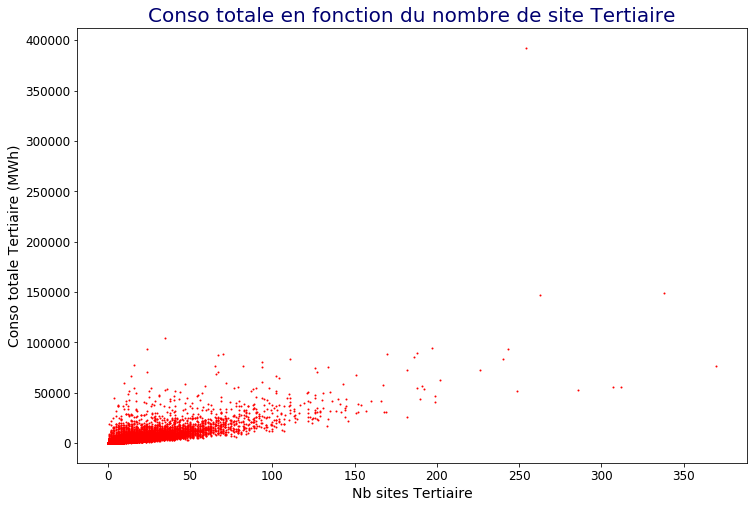

In [25]:
plt.close()
fig = plt.figure(figsize=(12,8))
ax = plt.axes()

plt.rcParams.update({'font.size': 15})

plt.scatter(conso_per_iris_set['Nb sites Tertiaire'], conso_per_iris_set['Conso totale Tertiaire (MWh)'],
         c='#FF0000', s=1)

plt.title("Conso totale en fonction du nombre de site Tertiaire", size=20, color="#000070")

# Titres des axes
ax = ax.set(xlabel='Nb sites Tertiaire', ylabel='Conso totale Tertiaire (MWh)')
plt.show()

Again we will drop values where the total consumption is greater than 50000 or the number os site is greater than 130 (cf histogram few lines above).

In [26]:
# If we had to study the consumption for tertiaire we would do as below
#conso_per_iris_set = conso_per_iris_set[conso_per_iris_set['Conso totale Tertiaire (MWh)'] <= 50000]
#conso_per_iris_set = conso_per_iris_set[conso_per_iris_set['Nb sites Tertiaire'] <= 130]  

However, our objective is to train on residential sector only. Therefore we will restrain on residential sector only and we will drop other columns. Moreover if we wanted to go further in the project the total consumption of the other value should also be computed and we wouldn't be able to use them. Also this operation allow us to decrease the dimension of our dataset.

In [27]:
conso_per_iris_set = conso_per_iris_set.drop(['Nb sites Tertiaire','Conso totale Tertiaire (MWh)', 
                                              'Nb sites Industrie', 'Conso totale Industrie (MWh)',  
                                              'Nb sites Agriculture', 'Conso totale Agriculture (MWh)',  
                                              'Nb sites Professionnel', 'Conso totale Professionnel (MWh)',
                                             'Conso moyenne Professionnel (MWh)'], axis=1) 

### 1. Is electricity consumption explainable from external data?

To respond to that question we will study the `logement_set`. First we need to drop redundant columns (present in the dataset from ENEDIS) except the IRIS Code wich is the identifier. Let's see the content of the dataset with `describe`.

NB : we will consider that they were no mistake in the ENEDIS dataset. Indeed we should have verify that all common features contains the same rows (for these tuplet of features), elsewhere this could be a mistake and we would not be able to say which of ENEDIS or INSEE who was responsible.

In [28]:
logement = raw_logement.drop(["REG", "DEP", "UU2010", "COM", "LIBCOM", "TRIRIS", "GRD_QUART", "LIBIRIS", 
                        "TYP_IRIS", "MODIF_IRIS", "LAB_IRIS"], axis=1).dropna(axis='columns', how='all')
logement = logement.loc[:, logement.isnull().mean() <= .5]
logement = logement.dropna()

Here we have also delete columns where the number of NaN values was exceeding 50% of the column. Then we have removed the row with nan values.

In fact if we analyse our features we can see that we have removed DOM departements and remove their specific features. For more information please see the description of the features in the excel named `base-ic-logement-2014.xls` in the tab `Variables`

In [29]:
logement.describe(include='all')

,IRIS,P14_LOG,P14_RP,P14_RSECOCC,P14_LOGVAC,P14_MAISON,P14_APPART,P14_RP_1P,P14_RP_2P,P14_RP_3P,P14_RP_4P,P14_RP_5PP,P14_NBPI_RP,P14_RPMAISON,P14_NBPI_RPMAISON,P14_RPAPPART,P14_NBPI_RPAPPART,P14_RP_M30M2,P14_RP_3040M2,P14_RP_4060M2,P14_RP_6080M2,P14_RP_80100M2,P14_RP_100120M2,P14_RP_120M2P,P14_RP_ACHTOT,P14_RP_ACH19,P14_RP_ACH45,P14_RP_ACH70,P14_RP_ACH90,P14_RP_ACH05,P14_RP_ACH11,P14_RPMAISON_ACHTOT,P14_RPMAISON_ACH19,P14_RPMAISON_ACH45,P14_RPMAISON_ACH70,P14_RPMAISON_ACH90,P14_RPMAISON_ACH05,P14_RPMAISON_ACH11,P14_RPAPPART_ACHTOT,P14_RPAPPART_ACH19,P14_RPAPPART_ACH45,P14_RPAPPART_ACH70,P14_RPAPPART_ACH90,P14_RPAPPART_ACH05,P14_RPAPPART_ACH11,P14_MEN,P14_MEN_ANEM0002,P14_MEN_ANEM0204,P14_MEN_ANEM0509,P14_MEN_ANEM10P,P14_PMEN,P14_PMEN_ANEM0002,P14_PMEN_ANEM0204,P14_PMEN_ANEM0509,P14_PMEN_ANEM10P,P14_NBPI_RP_ANEM0002,P14_NBPI_RP_ANEM0204,P14_NBPI_RP_ANEM0509,P14_NBPI_RP_ANEM10P,P14_RP_PROP,P14_RP_LOC,P14_RP_LOCHLMV,P14_RP_GRAT,P14_NPER_RP,P14_NPER_RP_PROP,P14_NPER_RP_LOC,P14_NPER_RP_LOCHLMV,P14_NPER_RP_GRAT,P14_ANEM_RP,P14_ANEM_RP_PROP,P14_ANEM_RP_LOC,P14_ANEM_RP_LOCHLMV,P14_ANEM_RP_GRAT,P14_RP_SDB,P14_RP_CCCOLL,P14_RP_CCIND,P14_RP_CINDELEC,P14_RP_GARL,P14_RP_VOIT1P,P14_RP_VOIT1,P14_RP_VOIT2P
count,49404,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000,49404.000000
unique,49404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,401240000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,687.052406,567.659059,65.811974,53.581373,382.940424,297.167755,32.636415,71.851877,119.374186,142.813344,200.983238,2263.774012,320.553918,1547.901057,242.294908,707.227975,26.551834,33.119827,82.821788,123.712944,130.990952,84.086387,86.375326,554.367398,85.225527,54.186572,124.074445,162.344394,85.761376,42.775084,313.200565,56.705112,33.200923,53.387664,93.445103,51.862462,24.599301,236.552748,27.948862,20.608394,69.813671,67.370217,33.062082,17.749522,567.659059,74.081358,114.188783,97.572230,281.816688,1266.378179,150.396524,263.155285,251.308081,601.518289,230.649929,394.624581,386.156742,1252.342760,327.833995,226.824937,83.320739,13.000127,1266.378179,769.648989,470.577176,194.788102,26.152014,8596.235634,6575.028977

As you can see above, some features seem to have outliers. For example the feature `P14_RPAPPART_ACH11` (which represent the number of principal residence of type appartement built between 2006 and 2011) has its third quartil equal to 9 and it's max value to 2396 which seem very unlikely.

In order to remove these outliers we will use the Z score. In a few words the Z score is the number of standard deviations from the mean a data point is (imagin a gaussian distribution) which basically mean than greater the Z score greater the number of values kept is. A Z score of 1 corresponds to 2\*34.13=68.26% of value kept (34.13 on both sides from the mean), 2 corresponds to 2\*47.72= 95.44 and 3 for 2\*49.87=99.74. Here we will take a z-score of 2.8 because we will keep 99.5% of the values.

More information about the Z-score here : http://jukebox.esc13.net/untdeveloper/RM/Stats_Module_4/mobile_pages/Stats_Module_47.html

In [30]:
from scipy import stats

logement_IRIS = logement[["IRIS"]]
logement_cleared = logement.drop(["IRIS"], axis=1)
logement_cleared = logement_cleared[(np.abs(stats.zscore(logement_cleared)) < 2.82).all(axis=1)]

We join the datafram with the index feature and then we merge with our ENEDIS dataset on the index feature `Code IRIS`.

In [31]:
logement_cleared = logement_cleared.join(logement_IRIS)
logement_cleared = logement_cleared.rename(columns={'IRIS' : 'Code IRIS'})

In [32]:
conso_per_iris_set = pd.merge(conso_per_iris_set, logement_cleared, on='Code IRIS')
conso_per_iris_set.describe(include='all')

,Code IRIS,Type IRIS,Type EPCI,Nom département,Nom région,Nb sites Résidentiel,Conso totale Résidentiel (MWh),Conso moyenne Résidentiel (MWh),Nombre d'habitants,Taux de logements collectifs,Taux de résidences principales,Superficie des logements < 30 m2,Superficie des logements 30 à 40 m2,Superficie des logements 40 à 60 m2,Superficie des logements 60 à 80 m2,Superficie des logements 80 à 100 m2,Superficie des logements > 100 m2,Résidences principales avant 1919,Résidences principales de 1919 à 1945,Résidences principales de 1946 à 1970,Résidences principales de 1971 à 1990,Résidences principales de 1991 à 2005,Résidences principales de 2006 à 2010,Résidences principales après 2011,Taux de chauffage électrique,Latitude,Longitude,P14_LOG,P14_RP,P14_RSECOCC,P14_LOGVAC,P14_MAISON,P14_APPART,P14_RP_1P,P14_RP_2P,P14_RP_3P,P14_RP_4P,P14_RP_5PP,P14_NBPI_RP,P14_RPMAISON,P14_NBPI_RPMAISON,P14_RPAPPART,P14_NBPI_RPAPPART,P14_RP_M30M2,P14_RP_3040M2,P14_RP_4060M2,P14_RP_6080M2,P14_RP_80100M2,P14_RP_100120M2,P14_RP_120M2P,P14_RP_ACHTOT,P14_RP_ACH19,P14_RP_ACH45,P14_RP_ACH70,P14_RP_ACH90,P14_RP_ACH05,P14_RP_ACH11,P14_RPMAISON_ACHTOT,P14_RPMAISON_ACH19,P14_RPMAISON_ACH45,P14_RPMAISON_ACH70,P14_RPMAISON_ACH90,P14_RPMAISON_ACH05,P14_RPMAISON_ACH11,P14_RPAPPART_ACHTOT,P14_RPAPPART_ACH19,P14_RPAPPART_ACH45,P14_RPAPPART_ACH70,P14_RPAPPART_ACH90,P14_RPAPPART_ACH05,P14_RPAPPART_ACH11,P14_MEN,P14_MEN_ANEM0002,P14_MEN_ANEM0204,P14_MEN_ANEM0509,P14_MEN_ANEM10P,P14_PMEN,P14_PMEN_ANEM0002,P14_PMEN_ANEM0204,P14_PMEN_ANEM0509,P14_PMEN_ANEM10P,P14_NBPI_RP_ANEM0002,P14_NBPI_RP_ANEM0204,P14_NBPI_RP_ANEM0509,P14_NBPI_RP_ANEM10P,P14_RP_PROP,P14_RP_LOC,P14_RP_LOCHLMV,P14_RP_GRAT,P14_NPER_RP,P14_NPER_RP_PROP,P14_NPER_RP_LOC,P14_NPER_RP_LOCHLMV,P14_NPER_RP_GRAT,P14_ANEM_RP,P14_ANEM_RP_PROP,P14_ANEM_RP_LOC,P14_ANEM_RP_LOCHLMV,P14_ANEM_RP_GRAT,P14_RP_SDB,P14_RP_CCCOLL,P14_RP_CCIND,P14_RP_CINDELEC,P14_RP_GARL,P14_RP_VOIT1P,P14_RP_VOIT1,P14_RP_VOIT2P
count,30145,30145,30145,30145,30145,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000
unique,30145,4,5,93,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,764700000,Z,CC,Seine-Maritime,Auvergne-Rhône-Alpes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

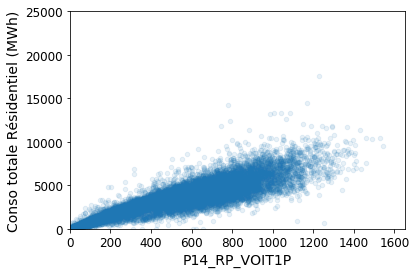

In [33]:
conso_per_iris_set.plot(kind="scatter", x="P14_RP_VOIT1P", y="Conso totale Résidentiel (MWh)",
             alpha=0.1)
plt.axis([0, 1650, 0, 25000]);

This graph show that it seems that the total consumption if related to the possession of at least one car. Moreover if we try other features from the INSEE dataset, we will see that they might be a correlation with the consumption. 

We will study more precisely the correlation with the consumption with the question 2

### 4. Are there major differences in consumption by department or region? If so, what are these differences? Propose some reason behind these differences
We will continue with question 4 because it interesting to present the values before scaling.

For this analyse we will use pivot table as it is a very easy and efficient way to respond to our question. As it it only to study and we won't change the data, we will use the full dataset

In [34]:
table = pd.pivot_table(conso_per_iris_set, values=['Conso totale Résidentiel (MWh)'], index=['Nom région'],aggfunc=np.mean)
table

,Conso totale Résidentiel (MWh)
Nom région,
Auvergne-Rhône-Alpes,2421.048774
Bourgogne-Franche-Comté,1499.618317
Bretagne,3083.301140
Centre-Val de Loire,2296.142761
Grand-Est,1517.447613
Hauts-de-France,1880.994306
Normandie,1986.519176
Nouvelle Aquitaine,1948.807984
Occitanie,1793.895615


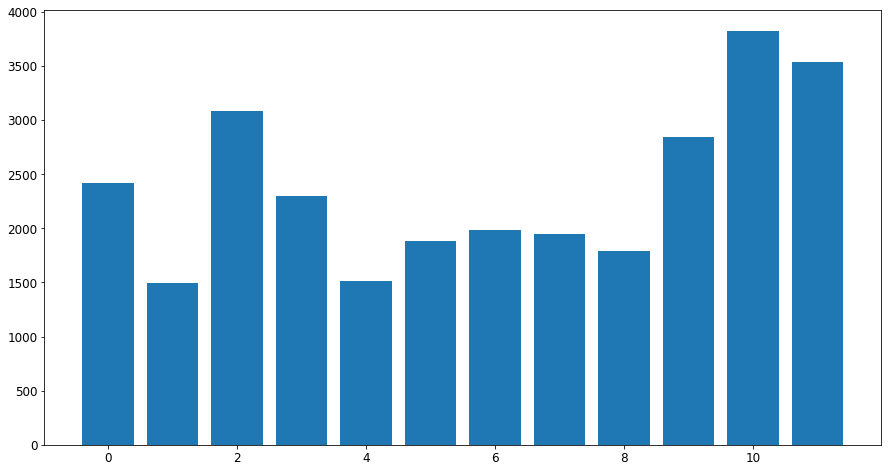

In [35]:
plt.close()
fig = plt.figure(figsize=(15,8))
ax = plt.axes()
plt.bar(np.arange(len(table.index)), table["Conso totale Résidentiel (MWh)"].to_list())
plt.show();

In [36]:
table = pd.pivot_table(conso_per_iris_set, values=['Conso totale Résidentiel (MWh)'], index=['Nom département'],aggfunc=np.mean)
table

,Conso totale Résidentiel (MWh)
Nom département,
Ain,2850.896233
Aisne,1387.880397
Allier,1793.014256
Alpes-Maritimes,3967.414296
Alpes-de-Haute-Provence,1868.616248
Ardennes,1116.086477
Ardèche,2273.078949
Ariège,1067.801618
Aube,1448.223029


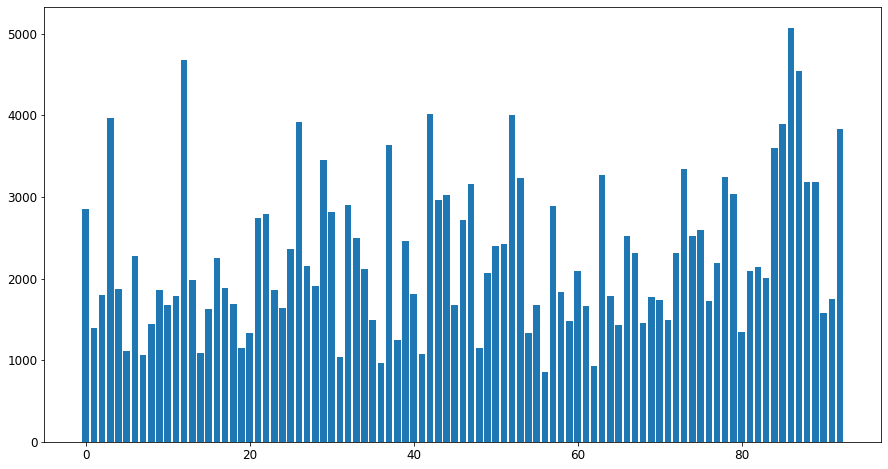

In [37]:
plt.close()
fig = plt.figure(figsize=(15,8))
ax = plt.axes()
plt.bar(np.arange(len(table.index)), table["Conso totale Résidentiel (MWh)"].to_list())
plt.show();

It is obvious that, from a region to another, from a departement to another, the total consumption is changing a lot. So we want to say that obviously the consumption is affected by the location. 

However, I want to draw you attention on the values we are showing. Indeed these values are the mean (of a region or departement) of the total value of consumption expressed in MWh. Therefore, if a region (or departement) has a bigger number of sites than another, then it may have also a bigger consumtpion. Therefore, I propose to see the mean of average consumption by region/departement and we'll try to see if the location is relevant.

In [38]:
table = pd.pivot_table(conso_per_iris_set, values=['Conso moyenne Résidentiel (MWh)'], index=['Nom région'],aggfunc=np.mean)
table

,Conso moyenne Résidentiel (MWh)
Nom région,
Auvergne-Rhône-Alpes,5.211693
Bourgogne-Franche-Comté,5.219164
Bretagne,5.366744
Centre-Val de Loire,6.167216
Grand-Est,5.793788
Hauts-de-France,5.993329
Normandie,6.360765
Nouvelle Aquitaine,5.649525
Occitanie,5.245426


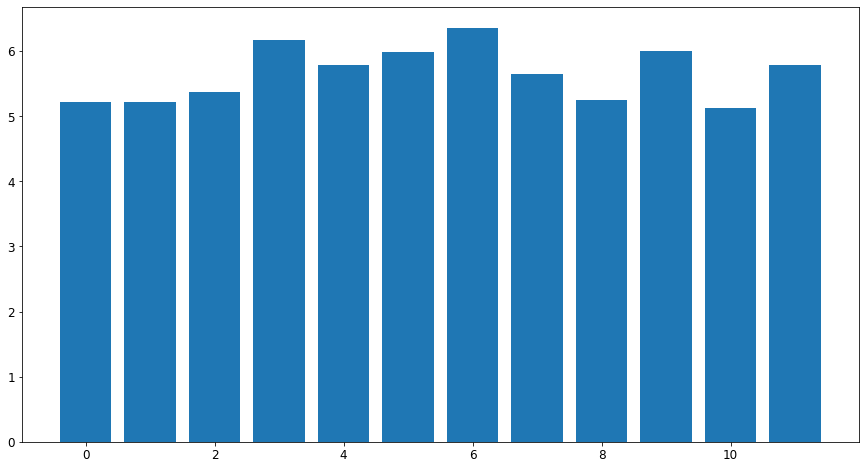

In [39]:
plt.close()
fig = plt.figure(figsize=(15,8))
ax = plt.axes()
plt.bar(np.arange(len(table.index)), table["Conso moyenne Résidentiel (MWh)"].to_list())
plt.show();

In [40]:
table = pd.pivot_table(conso_per_iris_set, values=['Conso moyenne Résidentiel (MWh)'], index=['Nom département'],aggfunc=np.mean)
table

,Conso moyenne Résidentiel (MWh)
Nom département,
Ain,6.121843
Aisne,6.144338
Allier,5.465156
Alpes-Maritimes,4.810640
Alpes-de-Haute-Provence,4.571199
Ardennes,5.140654
Ardèche,4.514879
Ariège,4.426644
Aube,6.312301


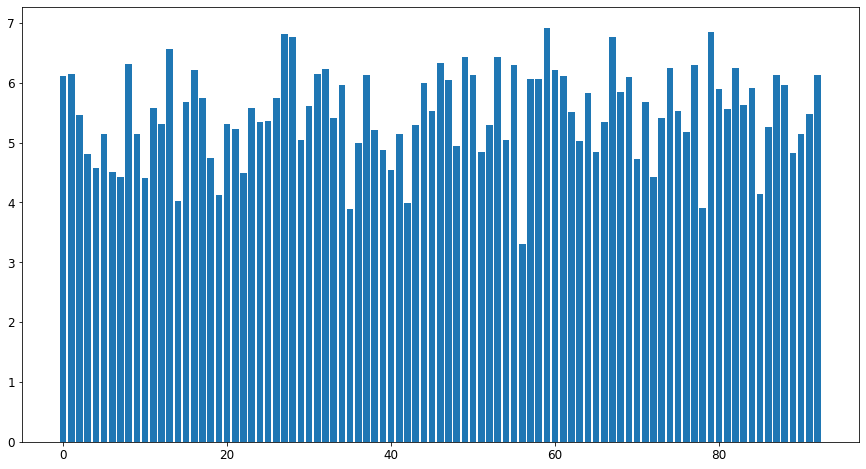

In [41]:
plt.close()
fig = plt.figure(figsize=(15,8))
ax = plt.axes()
plt.bar(np.arange(len(table.index)), table["Conso moyenne Résidentiel (MWh)"].to_list())
plt.show();

Whereas consumption do not vary fluctuate much for region, it fluctuates more between departements. It could be explained as the change in temperature or population density.

As it seems relevant to consider these values, it could be enteresting to use OneHotEncoder on the departement (doing this on region and departement would be redundant as departement is a sub-region). However as we have about 95 departement, it will add about 95 features to our dataframe and even if we use a PCA to reduce dimension, we could keep maybe 25% of this features which is already to much.

Therefore, we gonna use the coefficient determined here and associate each one of them to the department it describes. Therefore we will add one column to our dataframe we could still use a PCA do decrease dimension. We will do so after splitting our dataset.

## Scale Data
As we can see on the above graph, some features need to be scaled. But first we have to distinct the training set from the testing set. Indeed the testing set need to be scaled with mean and std of the training set

### Create a Test Set

In [42]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(conso_per_iris_set, test_size=0.2, random_state=42)
print(train_set.shape, test_set.shape)

(24116, 107) (6029, 107)


As sayd above we will add the column `Conso totale Résidentiel (MWh)` by departement.

In [43]:
def addDepartementFeature(train, test):
    table = pd.pivot_table(train, values=['Conso totale Résidentiel (MWh)'], index=['Nom département'],aggfunc=np.mean)
    table = table.rename(columns={'Conso totale Résidentiel (MWh)' : 'Conso totale Résidentiel (MWh)_depart'})
    train_set = pd.merge(train, table, on='Nom département')
    test_set = pd.merge(test, table, on='Nom département')
    return train_set, test_set
train_set, test_set = addDepartementFeature(train_set, test_set)

Now, scale data on non category and non object features.

In [44]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

def scaling(train, test, scaler, ignored_features):
    scaled_train = train.copy()
    scaled_test = test.copy()
    features_train = scaled_train.drop(ignored_features, axis=1)
    features_test = scaled_test.drop(ignored_features, axis=1)
    columns = features_train.columns
    
    scaler = scaler.fit(features_train.values)
    features_train = scaler.transform(features_train.values)
    features_test = scaler.transform(features_test.values)
    
    scaled_train[columns] = features_train
    scaled_test[columns] = features_test
    return scaled_train, scaled_test

In [45]:
scaled_train_set, scaled_test_set = scaling(train_set, test_set, scaler, 
                            ["Code IRIS", "Type IRIS", "Type EPCI", "Nom département", "Nom région", "Conso totale Résidentiel (MWh)", "Conso moyenne Résidentiel (MWh)"])

Check the data is scaled :

In [46]:
scaled_train_set.describe(include='all')

,Code IRIS,Type IRIS,Type EPCI,Nom département,Nom région,Nb sites Résidentiel,Conso totale Résidentiel (MWh),Conso moyenne Résidentiel (MWh),Nombre d'habitants,Taux de logements collectifs,Taux de résidences principales,Superficie des logements < 30 m2,Superficie des logements 30 à 40 m2,Superficie des logements 40 à 60 m2,Superficie des logements 60 à 80 m2,Superficie des logements 80 à 100 m2,Superficie des logements > 100 m2,Résidences principales avant 1919,Résidences principales de 1919 à 1945,Résidences principales de 1946 à 1970,Résidences principales de 1971 à 1990,Résidences principales de 1991 à 2005,Résidences principales de 2006 à 2010,Résidences principales après 2011,Taux de chauffage électrique,Latitude,Longitude,P14_LOG,P14_RP,P14_RSECOCC,P14_LOGVAC,P14_MAISON,P14_APPART,P14_RP_1P,P14_RP_2P,P14_RP_3P,P14_RP_4P,P14_RP_5PP,P14_NBPI_RP,P14_RPMAISON,P14_NBPI_RPMAISON,P14_RPAPPART,P14_NBPI_RPAPPART,P14_RP_M30M2,P14_RP_3040M2,P14_RP_4060M2,P14_RP_6080M2,P14_RP_80100M2,P14_RP_100120M2,P14_RP_120M2P,P14_RP_ACHTOT,P14_RP_ACH19,P14_RP_ACH45,P14_RP_ACH70,P14_RP_ACH90,P14_RP_ACH05,P14_RP_ACH11,P14_RPMAISON_ACHTOT,P14_RPMAISON_ACH19,P14_RPMAISON_ACH45,P14_RPMAISON_ACH70,P14_RPMAISON_ACH90,P14_RPMAISON_ACH05,P14_RPMAISON_ACH11,P14_RPAPPART_ACHTOT,P14_RPAPPART_ACH19,P14_RPAPPART_ACH45,P14_RPAPPART_ACH70,P14_RPAPPART_ACH90,P14_RPAPPART_ACH05,P14_RPAPPART_ACH11,P14_MEN,P14_MEN_ANEM0002,P14_MEN_ANEM0204,P14_MEN_ANEM0509,P14_MEN_ANEM10P,P14_PMEN,P14_PMEN_ANEM0002,P14_PMEN_ANEM0204,P14_PMEN_ANEM0509,P14_PMEN_ANEM10P,P14_NBPI_RP_ANEM0002,P14_NBPI_RP_ANEM0204,P14_NBPI_RP_ANEM0509,P14_NBPI_RP_ANEM10P,P14_RP_PROP,P14_RP_LOC,P14_RP_LOCHLMV,P14_RP_GRAT,P14_NPER_RP,P14_NPER_RP_PROP,P14_NPER_RP_LOC,P14_NPER_RP_LOCHLMV,P14_NPER_RP_GRAT,P14_ANEM_RP,P14_ANEM_RP_PROP,P14_ANEM_RP_LOC,P14_ANEM_RP_LOCHLMV,P14_ANEM_RP_GRAT,P14_RP_SDB,P14_RP_CCCOLL,P14_RP_CCIND,P14_RP_CINDELEC,P14_RP_GARL,P14_RP_VOIT1P,P14_RP_VOIT1,P14_RP_VOIT2P,Conso totale Résidentiel (MWh)_depart
count,24116,24116,24116,24116,24116,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000
unique,24116,4,5,93,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,764700000,Z,CC,Seine-Maritime,Auvergne-Rhône-Alpes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

Now we print the consumption and the number of residential sites as a function of the latitude and longitude. In fact we create a map where the circle represent the number of sites and the color represents the consumption.

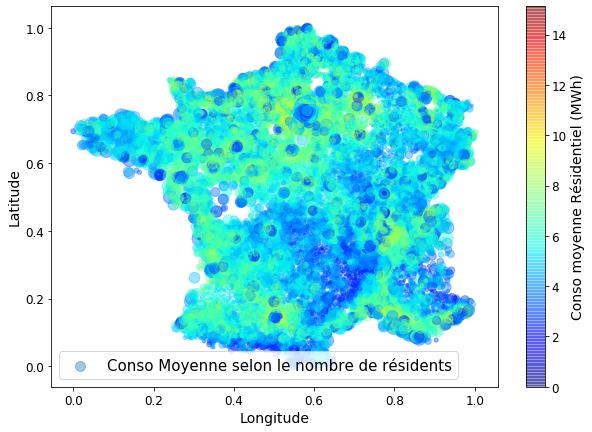

In [47]:
scaled_train_set.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.4,
             s=scaled_train_set["Nb sites Résidentiel"]*200, label="Conso Moyenne selon le nombre de résidents", figsize=(10,7),
             c="Conso moyenne Résidentiel (MWh)", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False) # last argument for a library bug
plt.legend();

## Looking for correlations
### 2. What are the features, or group of features correlated with electricity consumption?
Since the dataset is not too large, we can easily compute the standard correlation coefficient between every pair of attributes using the `corr()` method:

In [48]:
corr_matrix = scaled_train_set.corr()
corr_matrix

,Nb sites Résidentiel,Conso totale Résidentiel (MWh),Conso moyenne Résidentiel (MWh),Nombre d'habitants,Taux de logements collectifs,Taux de résidences principales,Superficie des logements < 30 m2,Superficie des logements 30 à 40 m2,Superficie des logements 40 à 60 m2,Superficie des logements 60 à 80 m2,Superficie des logements 80 à 100 m2,Superficie des logements > 100 m2,Résidences principales avant 1919,Résidences principales de 1919 à 1945,Résidences principales de 1946 à 1970,Résidences principales de 1971 à 1990,Résidences principales de 1991 à 2005,Résidences principales de 2006 à 2010,Résidences principales après 2011,Taux de chauffage électrique,Latitude,Longitude,P14_LOG,P14_RP,P14_RSECOCC,P14_LOGVAC,P14_MAISON,P14_APPART,P14_RP_1P,P14_RP_2P,P14_RP_3P,P14_RP_4P,P14_RP_5PP,P14_NBPI_RP,P14_RPMAISON,P14_NBPI_RPMAISON,P14_RPAPPART,P14_NBPI_RPAPPART,P14_RP_M30M2,P14_RP_3040M2,P14_RP_4060M2,P14_RP_6080M2,P14_RP_80100M2,P14_RP_100120M2,P14_RP_120M2P,P14_RP_ACHTOT,P14_RP_ACH19,P14_RP_ACH45,P14_RP_ACH70,P14_RP_ACH90,P14_RP_ACH05,P14_RP_ACH11,P14_RPMAISON_ACHTOT,P14_RPMAISON_ACH19,P14_RPMAISON_ACH45,P14_RPMAISON_ACH70,P14_RPMAISON_ACH90,P14_RPMAISON_ACH05,P14_RPMAISON_ACH11,P14_RPAPPART_ACHTOT,P14_RPAPPART_ACH19,P14_RPAPPART_ACH45,P14_RPAPPART_ACH70,P14_RPAPPART_ACH90,P14_RPAPPART_ACH05,P14_RPAPPART_ACH11,P14_MEN,P14_MEN_ANEM0002,P14_MEN_ANEM0204,P14_MEN_ANEM0509,P14_MEN_ANEM10P,P14_PMEN,P14_PMEN_ANEM0002,P14_PMEN_ANEM0204,P14_PMEN_ANEM0509,P14_PMEN_ANEM10P,P14_NBPI_RP_ANEM0002,P14_NBPI_RP_ANEM0204,P14_NBPI_RP_ANEM0509,P14_NBPI_RP_ANEM10P,P14_RP_PROP,P14_RP_LOC,P14_RP_LOCHLMV,P14_RP_GRAT,P14_NPER_RP,P14_NPER_RP_PROP,P14_NPER_RP_LOC,P14_NPER_RP_LOCHLMV,P14_NPER_RP_GRAT,P14_ANEM_RP,P14_ANEM_RP_PROP,P14_ANEM_RP_LOC,P14_ANEM_RP_LOCHLMV,P14_ANEM_RP_GRAT,P14_RP_SDB,P14_RP_CCCOLL,P14_RP_CCIND,P14_RP_CINDELEC,P14_RP_GARL,P14_RP_VOIT1P,P14_RP_VOIT1,P14_RP_VOIT2P,Conso totale Résidentiel (MWh)_depart
Nb sites Résidentiel,1.000000,0.911707,-0.231261,0.956141,0.578619,0.269128,0.190991,0.356300,0.426086,0.393585,0.004588,-0.475529,-0.505278,-0.067400,0.451895,0.381018,0.079414,-0.083340,-0.035873,0.264742,-0.032806,-0.018706,0.990576,0.978959,0.262160,0.794229,0.813795,0.747789,0.557721,0.780571,0.882044,0.930449,0.820604,0.956806,0.819676,0.808027,0.734417,0.721483,0.509171,0.705752,0.809935,0.873850,0.897415,0.813520,0.697647,0.977918,0.520554,0.693999,0.786522,0.857339,0.783267,0.677690,0.822282,0.408910,0.629302,0.769495,0.718423,0.641654,0.505152,0.729372,0.497094,0.535608,0.581207,0.606617,0.592070,0.543385,0.978959,0.891736,0.934308,0.945728,0.948105,0.954502,0.910614,0.924617,0.901443,0.914831,0.914051,0.939874,0.923798,0.917453,0.911984,0.844287,0.576442,0.719815,0.954502,0.870234,0.822385,0.546417,0.687106,0.942259,0.884990,0.735080,0.529809,0.578545,0.978275,0.523183,0.874886,0.841091,0.932910,0.968041,0.962632,0.840343,0.411616
Conso totale Résidentiel (MWh),0.911707,1.000000,0.081925,0.914201,0.329342,0.318099,0.093121,0.195111,0.213042,0.189922,0.068068,-0.262203,-0.477506,-0.116572,0.254681,0.409362,0.213671,0.014913,0.016286,0.435630,-0.019518,-0.041718,0.900192,0.902585,0.211381,0.659881,0.900252,0.488433,0.375938,0.576947,0.696165,0.860956,0.899066,0.934398,0.917574,0.913654,0.478398,0.464608,0.348744,0.514617,0.592664,0.681678,0.870281,0.899545,0.846936,0.897814,0.559592,0.569404,0.574837,0.807709,0.835636,0.732288,0.916518,0.502176,0.560754,0.711181,0.830369,0.803618,0.667695,0.472012,0.392198,0.360074,0.323661,0.375490,0.445912,0.432578,0.902585,0.753322,0.810821,0.871488,0.913294,0.918731,0.807029,0.839513,0.873373,0.917942,0.824389,0.867325,0.906898,0.922885,0.939298,0.640759,0.377380,0.679166,0.918731,0.934136,0.637502,0.359034,0.660051,0.899005,0.900231,0.524268,0.334021,0.572281,0.904612,0.284630,0.773717,0.897874,0.932048,0.933910,0.824684,0.940036,0.444462
Conso moyenne Résidentiel (MWh),-0.231261,0.081925,1.000000,-0.139424,-0.499252,0.376802,-0.224659,-0.391249,-0.531985,-0.526462,0.086315,0.589578,-0.012882,

As we want to see the correlation between features we will, for each consumption sector, the correlation Matrix 

### Résidentiel

In [49]:
corr_matrix["Conso moyenne Résidentiel (MWh)"].sort_values(ascending=False)

Conso moyenne Résidentiel (MWh)          1.000000
Superficie des logements > 100 m2        0.589578
Taux de chauffage électrique             0.482432
Taux de résidences principales           0.376802
Résidences principales de 1991 à 2005    0.331073
Résidences principales de 2006 à 2010    0.298431
P14_RPMAISON_ACH11                       0.240753
P14_RP_120M2P                            0.218553
P14_RPMAISON_ACH05                       0.205645
Latitude                                 0.184884
Résidences principales après 2011        0.128480
P14_RP_VOIT2P                            0.102003
P14_NBPI_RPMAISON                        0.098657
P14_RPMAISON_ACH90                       0.097914
P14_RPMAISON_ACH19                       0.095420
Résidences principales de 1971 à 1990    0.092897
Superficie des logements 80 à 100 m2     0.086315
Conso totale Résidentiel (MWh)           0.081925
P14_RPMAISON                             0.075694
P14_RP_100120M2                          0.071528


In [50]:
corr_matrix["Conso totale Résidentiel (MWh)"].sort_values(ascending=False)

Conso totale Résidentiel (MWh)           1.000000
P14_RP_VOIT2P                            0.940036
P14_RP_PROP                              0.939298
P14_NBPI_RP                              0.934398
P14_NPER_RP_PROP                         0.934136
P14_RP_VOIT1P                            0.933910
P14_RP_GARL                              0.932048
P14_NBPI_RP_ANEM10P                      0.922885
P14_PMEN                                 0.918731
P14_NPER_RP                              0.918731
P14_PMEN_ANEM10P                         0.917942
P14_RPMAISON                             0.917574
P14_RPMAISON_ACHTOT                      0.916518
Nombre d'habitants                       0.914201
P14_NBPI_RPMAISON                        0.913654
P14_MEN_ANEM10P                          0.913294
Nb sites Résidentiel                     0.911707
P14_NBPI_RP_ANEM0509                     0.906898
P14_RP_SDB                               0.904612
P14_RP                                   0.902585


For the dataset from ENEDIS :

As we can see, for the `Conso totale Résidentiel (MWh)` the features the best correlated are :
* `Nb sites Résidentiel`
* `Nombre d'habitants`
* `Taux de chauffage électrique`
* `Taux de logements collectifs`
* `Résidences principales avant 1919`

However the `Conso moyenne Résidentiel (MWh)` seems to have less correlated features with a great correlated coefficient. Here are some features correlated :
* `Superficie des logements > 100 m2`
* `Taux de chauffage électrique`
* `Taux de résidences principales`
* `Résidences principales de 1991 à 2005`

To answer question 1 more precisely, we clearly see that there is a correlation between the dataset from the website of INSEE especialy with the total consumption. Indeed the features the most correlated come from the INSEE dataset.

For the `Conso totale Résidentiel (MWh)` :
* P14_RP_PROP (Nombre de résidences principales occupées par des propriétaires)
* P14_RP_VOIT2P (Nombre de ménages disposant de deux voitures ou plus)
* P14_NBPI_RP (Nombre de pièces des résidences principales)
* P14_RP_VOIT1P (Nombre de ménages disposant au moins d'une voiture)
* P14_NPER_RP_PROP (Nombre de personnes des résidences principales occupées par des propriétaires)

For the `Conso moyenne Résidentiel (MWh)` :
* P14_RPMAISON_ACH11 (Nombre de résidences principales de type maison construites de 2006 à 2011)
* P14_RP_120M2P (Nombre de résidences principales de 120 m2 ou plus)
* P14_RPMAISON_ACH05 (Nombre de résidences principales de type maison construites de 1991 à 2005)

## Decrease dimensions
### 3. There might be a lot of dimensions in your data, how can you reduce dimensionality while keeping a maximum of information?
This is not a secret, the best ways is to realize a dimensionality reduction with the use of a PCA or a LDA algorithm. Indeed an algorithm like PCA will take all the features and creates new ones but in smaller number according to our parameter.


In [51]:
def removeLabels(t_set, labels):
    X = t_set.drop(labels, axis=1) 
    y = t_set[labels].copy()
    y["Longitude"] = t_set["Longitude"]
    y["Latitude"] = t_set["Latitude"]
    return X, y

In [52]:
X_train, y_train = removeLabels(scaled_train_set.copy(), ["Conso moyenne Résidentiel (MWh)", "Conso totale Résidentiel (MWh)"])
X_test, y_test = removeLabels(scaled_test_set.copy(), ["Conso moyenne Résidentiel (MWh)", "Conso totale Résidentiel (MWh)"])

Performing PCA using Scikit-Learn is a two-step process:

1. Initialize the PCA class by passing the number of components to the constructor.
2. Call the fit and then transform methods by passing the feature set to these methods. The transform method returns the specified number of principal components.

We first prepare ou custom PCA in order to return 2 numpy array with a smaller number of dimension.

In [53]:
# Print the shape of the dataset
X_train.shape

(24116, 106)

After some test with different values of n_components, we chose to assigned it 37 in order to get 99% of ratio of variance kept.

In [54]:
from sklearn.decomposition import PCA

pca = PCA(n_components=37)

def customPCA(pca, X_train, X_test, ignored_features):
    X_train_pac = X_train.drop(ignored_features, axis=1)
    X_test_pac = X_test.drop(ignored_features, axis=1)
    columns = X_train_pac.columns
    
    X_train_pac = pca.fit_transform(X_train_pac)
    X_test_pac = pca.transform(X_test_pac)
    
    explained_variance = pca.explained_variance_ratio_
    print("Ratio of variance kept",pca.explained_variance_ratio_.sum()*100, "%")
    #return np.hstack((X_train_pac, X_train.drop(columns, axis=1))), np.hstack((X_test_pac, X_test.drop(columns, axis=1)))
    return X_train_pac, X_test_pac

In [55]:
X_train_pca, X_test_pca = customPCA(pca, X_train, X_test, 
                              ignored_features =  ["Code IRIS", "Type IRIS", "Type EPCI", "Nom département", "Nom région"])

Ratio of variance kept 99.05464924916365 %


In [56]:
# The new shape of our dataset
X_train_pca.shape

(24116, 37)

### 5. Which departments have a large variation in electricity consumption? A small variation?

In [57]:
table = pd.pivot_table(conso_per_iris_set, values=['Conso totale Résidentiel (MWh)'], index=['Nom département'],aggfunc=np.std)
table

,Conso totale Résidentiel (MWh)
Nom département,
Ain,2089.662051
Aisne,1201.212250
Allier,1466.708784
Alpes-Maritimes,3389.823668
Alpes-de-Haute-Provence,1959.463571
Ardennes,1226.513842
Ardèche,2037.132420
Ariège,1087.105590
Aube,1449.540048


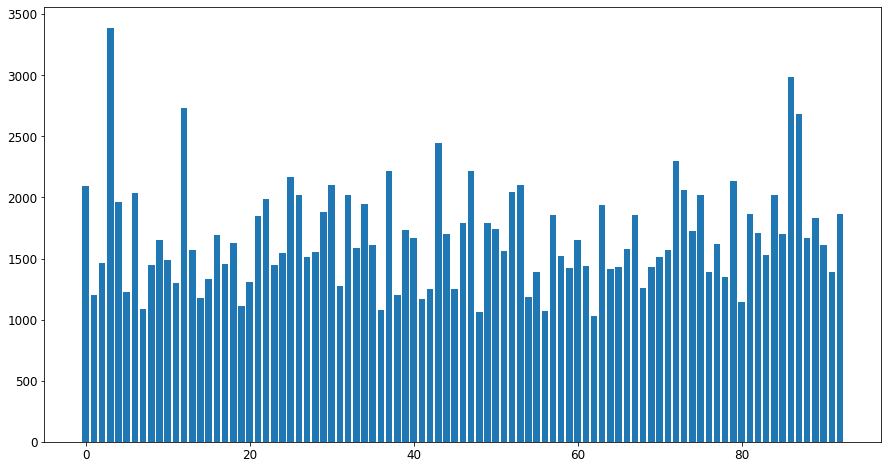

In [58]:
plt.close()
fig = plt.figure(figsize=(15,8))
ax = plt.axes()
plt.bar(np.arange(len(table.index)), table["Conso totale Résidentiel (MWh)"].to_list())
plt.show();

We can see here that departement like Ariège or Hautes-Pyrénées	have low variation of electricity consumption whereas  departements like Alpes-Maritimes and Var has high variation (factor 3 with the first two)

## Predict

After understanding all data, train a model on 2014 data to predict next year trends.

* Propose at least two different predictive methods, justify the choice motivation and explain the choice of your models’ parameters.

Optional but appreciable:
* Map visualization (on restricted areas or all territory)
* Dynamic application restitution

### RandomForestRegressor
So we will start with a RandomForestRegressor. With the RandomForestRegressor we will predict the total consumption value.

In [66]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.svm import NuSVR

def print_metrics(y_true, y_pred):
    print("MAE =", mean_absolute_error(y_pred.reshape(-1,1), y_true))
    print("MAPE = ",np.mean(np.abs(y_true - y_pred) / (0.5*(y_true+y_pred)+1)) * 100,"%")
    
def mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/((y_true+y_pred)/2 + 1)))

mape_scorer = make_scorer(mape, greater_is_better=False)

After exploring parameters threw documentation and test, we will ask our GridSearchCV to find better parameters.

In [60]:
param_grid = [
    # try 6 (3×2) combinations of hyperparameters
    {'n_estimators': [15,30,45],
     'max_features': [15, 20],
     'bootstrap': [False],
     'min_samples_leaf': [3],   # to try if time allows it [2,3,5,10]
     'min_samples_split': [2]}, # to try if time allows it [2,3,5,10]
]

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(random_state = 42)

# train across 4 folds, that's a total of (6)*4=24 rounds of training 
grid_search = GridSearchCV(rf, param_grid, cv=4, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train_pca, y_train['Conso totale Résidentiel (MWh)'])

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'bootstrap': [False], 'max_featu

In [61]:
params = grid_search.best_params_
params

{'bootstrap': False,
 'max_features': 20,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 45}

Above are the parameters that our gridsearchCV find the most promising.

In [62]:
rf = RandomForestRegressor(random_state = 42, **params)
rf.fit(X_train_pca, y_train['Conso totale Résidentiel (MWh)'])

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
                      max_features=20, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=45,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [63]:
print("Accuracy =", rf.score(X_train_pca , y_train['Conso totale Résidentiel (MWh)'])*100,"%")
print_metrics(y_train['Conso totale Résidentiel (MWh)'],rf.predict(X_train_pca))

Accuracy = 99.79018141107329 %
MAE = 30.5691892784253
MAPE =  1.9130952569466126 %


In [64]:
print("Accuracy =", rf.score(X_test_pca , y_test['Conso totale Résidentiel (MWh)'])*100,"%")
print_metrics(y_test['Conso totale Résidentiel (MWh)'],rf.predict(X_test_pca))

Accuracy = 95.70207332382871 %
MAE = 206.67711845831917
MAPE =  10.827447046607485 %


As we can see we obtained an accuracy of 95.7% which is relatively great. However we see that our MAE is equal to 206 which is satisfying but we could have hoped for less (which would have been better). The MAPE which represents the average percentage of imprecision (we are capable of predicting the total consumption at MAPE%) and is here of 10% which is also okay.

### NuSVR

Again, we explore the documentation and find that two approach are possibles with kernel equal to linear or rbf.

In [67]:
param_grid = [
    # try 3 combinations of hyperparameters
    {'kernel':['linear'],
     'C': [1, 0.6],
     'nu': [0.6],
     'gamma': ['auto']},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'kernel':['rbf'],
     'C': [1, 0.7,0.4],
     'nu': [0.6],
     'gamma': [0.5, 5]},
]

# Instantiate model with 1000 decision trees
clf = NuSVR(gamma='auto', kernel='linear')

# train across 3 folds, that's a total of (3+6)*3=27 rounds of training 
grid_search = GridSearchCV(clf, param_grid, cv=3, scoring=mape_scorer, return_train_score=True)
grid_search.fit(X_train_pca, y_train['Conso totale Résidentiel (MWh)'])

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=NuSVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                             gamma='auto', kernel='linear', max_iter=-1, nu=0.5,
                             shrinking=True, tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [1, 0.6], 'gamma': ['auto'],
                          'kernel': ['linear'], 'nu': [0.6]},
                         {'C': [1, 0.7, 0.4], 'gamma': [0.5, 5],
                          'kernel': ['rbf'], 'nu': [0.6]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=make_scorer(mape, greater_is_better=False), verbose=0)

In [68]:
params = grid_search.best_params_
params

{'C': 1, 'gamma': 'auto', 'kernel': 'linear', 'nu': 0.6}

In [69]:
clf = NuSVR(**params)
clf.fit(X_train_pca, y_train['Conso totale Résidentiel (MWh)'])

NuSVR(C=1, cache_size=200, coef0=0.0, degree=3, gamma='auto', kernel='linear',
      max_iter=-1, nu=0.6, shrinking=True, tol=0.001, verbose=False)

In [70]:
print("Accuracy =", clf.score(X_train_pca , y_train['Conso totale Résidentiel (MWh)'])*100,"%")
print_metrics(y_train['Conso totale Résidentiel (MWh)'],rf.predict(X_train_pca))

Accuracy = 94.40726261474448 %
MAE = 30.5691892784253
MAPE =  1.9130952569466126 %


In [71]:
print("Accuracy =", clf.score(X_test_pca , y_test['Conso totale Résidentiel (MWh)'])*100,"%")
print_metrics(y_test['Conso totale Résidentiel (MWh)'],clf.predict(X_test_pca))

Accuracy = 94.15044799710873 %
MAE = 245.42492082780933
MAPE =  12.514058182980856 %


So as we can see there is still a gap between training set and test set and we can guess there is overfitting on the training set as we can see the MAE and MAPE are very low for the training set and not that low for the testing set. So we should still try to optimize and test more optimized parameters with GridSearchCV or RandomizedSearch to reduce overfitting and improve our results on the test set. 

Moreover a neural network approach is possible and should be considered.

To conclude my RandomForestRegressor is slightly better than my SVR and should be chosen to predict future data.

In [72]:
conso_per_iris_set.nunique()

Code IRIS                                30145
Type IRIS                                    4
Type EPCI                                    5
Nom département                             93
Nom région                                  12
Nb sites Résidentiel                      1684
Conso totale Résidentiel (MWh)           30096
Conso moyenne Résidentiel (MWh)          30094
Nombre d'habitants                        3134
Taux de logements collectifs             25138
Taux de résidences principales           27345
Superficie des logements < 30 m2         16821
Superficie des logements 30 à 40 m2      21778
Superficie des logements 40 à 60 m2      25756
Superficie des logements 60 à 80 m2      26781
Superficie des logements 80 à 100 m2     26808
Superficie des logements > 100 m2        27520
Résidences principales avant 1919        27247
Résidences principales de 1919 à 1945    26251
Résidences principales de 1946 à 1970    26517
Résidences principales de 1971 à 1990    27117
Résidences pr

In [73]:
prediction_df = pd.DataFrame(rf.predict(X_test_pca), columns=['Conso total_pred'])

In [74]:
pred_vs_true = prediction_df.join(y_test)
pred_vs_true

,Conso total_pred,Conso moyenne Résidentiel (MWh),Conso totale Résidentiel (MWh),Longitude,Latitude
0,584.682166,2.338434,502.763272,0.708359,0.272859
1,2619.063420,3.936933,2338.537947,0.724154,0.271376
2,5345.095180,6.722529,5572.976155,0.758608,0.238914
3,1246.761227,4.778530,1122.954620,0.767933,0.302623
4,1564.372225,6.452314,1632.435451,0.770577,0.338087
5,1448.306004,5.786465,1556.559110,0.771801,0.335837
6,493.753939,4.947809,465.094024,0.748485,0.274022
7,4920.498082,4.950844,5168.680746,0.773125,0.298318
8,3821.314434,6.363377,3938.930560,0.736295,0.261013
9,5397.745129,3.833820,4665.759288,0.770183,0.280650


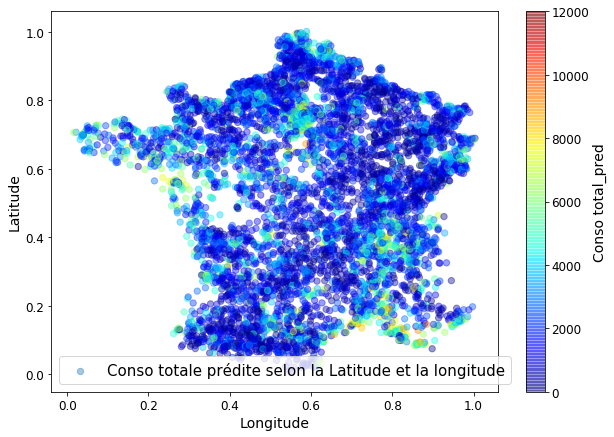

In [75]:
pred_vs_true.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.4,
             s=40, label="Conso totale prédite selon la Latitude et la longitude", figsize=(10,7),
             c="Conso total_pred", cmap=plt.get_cmap("jet"), vmin=0, vmax=12000, colorbar=True,
             sharex=False) # last argument for a library bug
plt.legend();

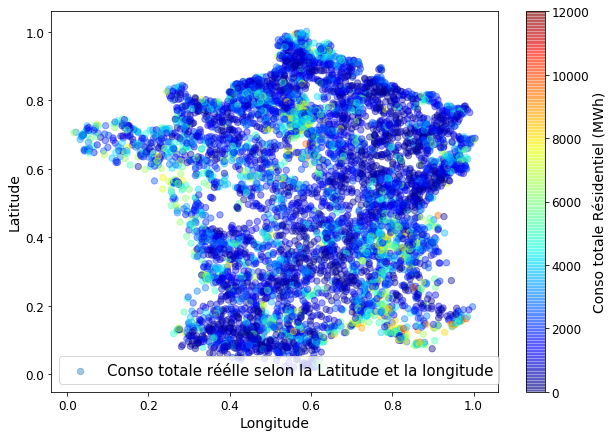

In [76]:
pred_vs_true.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.4,
             s=40, label="Conso totale réélle selon la Latitude et la longitude", figsize=(10,7),
             c="Conso totale Résidentiel (MWh)", cmap=plt.get_cmap("jet"), vmin=0, vmax=12000, colorbar=True,
             sharex=False) # last argument for a library bug
plt.legend();